<a href="https://colab.research.google.com/github/LuisCGit/6.484-reinforcement-learning/blob/main/value_policy_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2022 6.484 Computational Sensorimotor Learning Assignment 7

In this assignment, we will implement three principle reinforcement learning algorithms which provably converge to optimal solutions for MDPs:

*   Value iteration
*   Policy iteration
*   Q-learning

You will need to answer the bolded questions and fill in the missing code snippets (marked by **TODO**).

There are **230** total points to be had in this PSET.  `ctrl-f` for "pts" to ensure you don't miss questions.

**_Please fill in your name below:_**

**Name**: Luis Costa Laveron

### Credits

Some part of the code of this assignment is borrowed from the Spring 2018 CMU Deep Reinforcement Learning & Control course. We also thank Prof. [Cathy Wu](https://idss.mit.edu/staff/cathy-wu/) for polishing the content.

## Setup

The following code sets up imports and helper functions (you can ignore this).

In [1]:
%matplotlib inline
import numpy as np
import random
import time
import os
import gym
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd


from copy import deepcopy
from tqdm.notebook import tqdm
from dataclasses import dataclass
from matplotlib import animation
from IPython.display import HTML
from typing import Any
from collections import deque

mpl.rcParams['figure.dpi']= 100

In [2]:
# some util functions
def plot(logs, x_key, y_key, legend_key, **kwargs):
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)

# FrozenLake environment

*Winter has come.* You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:

```
SFFF # (S: starting point, safe)
FHFH # (F: frozen surface, safe)
FFFH # (H: hole, fall to your doom)
HFFG # (G: goal, where the frisbee is located)
```

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

Here's what the Frozen Lake looks like in action, when following a random agent:

![](https://miro.medium.com/max/690/1*ur_42c7MLhbi6q2L3JtSqg.gif)

Frozen Lake is part of OpenAI gym, a collection of open-source environments for benchmarking RL algorithms.   [Here](https://gym.openai.com/envs/FrozenLake-v0/) is a link to the gym environment (also the source of our environment description).

**Question:** What actions can the agent take at any given time step? (5 pts)

**Answer:** At every timestep the agent can choose from 4 actions:

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

Now, here's some code that creates the above environment through OpenAI gym, called `FrozenLake-v0`.  Note that we will be using a stochastic variant, so providing an action in a given direction will not always move you in that direction! When slippery, there is a 1/3 chance you move in the intended direction and a 1/3 chance each you move in a perpendicular direction.

In [3]:
## create FrozenLake environment
MAPS = {
    "4x4": [
        "GHFS",
        "FHHF",
        "FFHF",
        "FFFF"
    ],
    "8x8": [
        "FFFSFFFF",
        "FFFFFFFF",
        "HHHHFHFF",
        "FFFFFFHF",
        "FFFFFFFF",
        "FHFFFFHF",
        "FHFFHFHH",
        "FGHFFFFF"
    ],
}
from gym.envs.registration import register
env_name = 'Stochastic-4x4-FrozenLake-v0'
if env_name not in gym.envs.registry.env_specs:
    register(
        id=env_name,
        entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
        kwargs={'map_name': None,
                'is_slippery': True,
                'desc': MAPS['4x4']
                },
        max_episode_steps=20)

env_name = 'Stochastic-8x8-FrozenLake-v0'
if env_name not in gym.envs.registry.env_specs:
    register(
        id=env_name,
        entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
        kwargs={'map_name': None,
                'is_slippery': True,
                'desc': MAPS['8x8'],
                },
        max_episode_steps=100)

We would like to find a good policy for the agent (you, the brave soul). More precisely, the agent controls the movement of a character on the frozen lake. The frozen lake environment is an example of a _grid world_, since it consists of objects moving around in a discrete (grid) world. Grid world problems can constitute or approximate a wide class of problems.

**Question:** Consider a racecar environment, where the goal is to get the agent (the racecar) around a race track as quickly as possible. Is this suitable for representing as a grid world problem?  Justify your answer. (5 pts)

**Answer:** No, because the quantities and actions of interest in the racecar environment are continuous, whereas the grid world is more suited for discrete action spaces. Additionally, it is unclear how one would model a long,curvy race track as a series of squares on a grid.

Now let's return to the task at hand: retrieving our frisbee!
Remember that some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

Now let's consider some algorithms for solving this problem, i.e. finding a good policy to accomplish the task.

# Value Iteration

Value iteration is the first algorithm we will consider.

Let's first do a sanity check. In class, we learned that value iteration is model-based and as such, it is best for problems with small state spaces.

**Question:** Consider a fixed 4x4-grid FrozenLake. What is the size of the state space? (5 pts)

**Answer:** 

The state space is 4x4=16. Not bad! The reason that we don't have an exponential state space (e.g. $5^{16}$, where $5 = |\{S, F, H, G, A\}|$, and $A$ denotes the location of the agent) is because much of the grid world is fixed. The only part of the state that can change during the course of an episode is the location of the agent. The agent can appear in one of 4x4 locations, and thus the state space is 16. That is, although $5^{16}$ does provide a "first cut" at an upper bound on the state space, considering how much of the state can actually change can help dramatically to tighten the bound. On the other hand, if the task were to solve _any_ 4x4 FrozenLake, the state space would be much larger. Fortunately, you have a specific lake to cross to retrieve your frisbee.

Now recall from class that value iteration is a model-based method which starts with any guess of a value function $V_0$ and then updates it according to the optimal Bellman equation: $V_{i+1}(s) = \mathcal{T} V_i(s) = \max_a \mathbb{E}_{s' \sim p(\cdot | s, a)}[r(s, a, s') + \gamma V_i(s')]$.  In our case, as we have a fixed number of states, our value function is simply a mapping of square -> value (eg an array).

*Note:* we choose to represent actions as integers with the following mapping:

```
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
```

and states as zero-indexed integers traversing from the top left.

## Implement Value Iteration

*(20 pts)*

We will now implement value iteration over the MDP with transition probabilities described by `env.P` (transition probabilites), `env.nS` (number of states), and `env.nA` (number of actions). The entry `env.P[s][a]` (where `s` is the state index and `a` is the action index) is a list of transition tuples $(p(s,a,s'), s', r(s, a, s'), \text{episode_end})$ for each list index index `s'`.  In plain english:

 - $p(s,a,s')$: the probability of transitioning to state `s'` after taking action `a` in state `s`.
 - $s'$: the next state under this transition.
 - $r(s, a, s')$: the reward of taking this transition.
 - `episode_end`: a boolean representing whether taking this action ends the episode (in Frozen Lake, whether this kills you or takes you to the goal position).


In [4]:
# for example
env = gym.make('Stochastic-8x8-FrozenLake-v0')
env.P[0]

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 8, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 8, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 8, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

In [9]:
def value_iteration(env, gamma, max_iterations=1000, tol=1e-3):
    """Runs value iteration for a given gamma and environment.
    Updates states in their 1-N order.
    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.
    Returns
    -------
    np.ndarray, iteration, list
      The value function, the number of iterations it took to converge, and a list
      of the value functions after each iteration.
    """
    value_func = np.zeros(env.nS) # initial value function: all states are zero
    iters = 0
    value_history = []
    while True:
        delta = 0 # largest change in value function at any state between two iterations
        ###### TODO: value function update ##############
        for s in range(env.nS):
          exp = max([sum([prob*(r + gamma*value_func[s2]) for prob, s2, r, _ in env.P[s][a]]) for a in range(env.nA)])
          delta = max(delta, abs(exp - value_func[s]))
          value_func[s] = exp
        ################################################################
        # let's also save a copy of value function after each iteration
        value_history.append(value_func.copy())
        iters += 1
        if delta < tol or iters >= max_iterations:
            break
    return value_func, iters, value_history


$V_{i+1}(s) = \mathcal{T} V_i(s) = \max_a \mathbb{E}_{s' \sim p(\cdot | s, a)}[r(s, a, s') + \gamma V_i(s')]$

Actually, computing the optimal value function is not enough. What we are interested in is the optimal policy, not just how good each state is. Luckily, the optimal value function and the optimal policy are related. Let's implement this next:

*(20 pts)*

In [10]:
def value_function_to_policy(env, gamma, value_function):
    """Output action numbers for each state in value_function.
    Parameters
    ----------
    env: gym.core.Environment
      Environment to compute policy for. Must have nS, nA, and P as
      attributes.
    gamma: float
      Discount factor. Number in range [0, 1)
    value_function: np.ndarray
      Value of each state.
    Returns
    -------
    np.ndarray
      An array of integers. Each integer is the optimal action to take
      in that state according to the environment dynamics and the
      given value function.
    """
    policy = np.zeros(env.nS, dtype='int')
    for idx in range(env.nS):
        p = env.P[idx]
        vmax = -np.inf
        best_act = -1
        ###### TODO: Select the best action (best_act) ##############
        for a in range(env.nA):
          exp_a = sum([prob*(r + gamma*value_function[s2]) for prob, s2, r, _ in env.P[idx][a]])
          if exp_a > vmax:
            best_act = a
            vmax = exp_a
        ###################################################
        policy[idx] = best_act
    return policy



**Question**: What is the difference between the value iteration algorithm and extracting a policy from a value function? (5 pts)

**Answer**: 

OK enough talk, let's run it. We'll consider this 8x8 frozen lake:

```
FFFSFFFF
FFFFFFFF
HHHHFHFF
FFFFFFHF
FFFFFFFF
FHFFFFHF
FHFFHFHH
FGHFFFFF
```

## Visualization

Here are some helper functions for visualizing your value and policy functions.

In [11]:
def print_policy(policy):
    act_dict = {0: 'L', 1: 'D', 2: 'R', 3: 'U'}
    row = col = int(np.sqrt(policy.size))
    for i in range(row):
        for j in range(col):
            print(act_dict[policy[i * col + j]], end='')
        print('')

def print_value(value):
    row = col = int(np.sqrt(value.size))
    for i in range(row):
        for j in range(col):
            print('{0:.6f}'.format(value[i * col + j]), end=' ')
        print('')

def plot_value_history(value_history):
    row = col = int(np.sqrt(value_history[0].size))
    images = [x.reshape(row, col) for x in value_history]
    
    num_images = len(images)
    cols = int(np.sqrt(num_images))
    rows = int(np.ceil(num_images / cols))
    fig = plt.figure(figsize=(5, 12))
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / cols) + 1, cols, i + 1)
        plt.imshow(image)
        plt.xlabel(f'Iter: {i}')
    fig.tight_layout()


## Run value iteration

In [12]:
env = gym.make('Stochastic-8x8-FrozenLake-v0')
gamma = 0.9
value_info = value_iteration(env, gamma, max_iterations=int(1e3), tol=1e-4)
value, iters, value_history = value_info
policy = value_function_to_policy(env, gamma, value)
print('-----Policy: ')
print_policy(policy)
print('-----Value: ')
print_value(value)
print('-----Iterations: ', iters)

-----Policy: 
URRRRLLL
UUUURUUD
LLLLLLRR
DDDDDLLR
LUULLLDU
LLRUULLR
LLRLLLLL
DLLRDLDD
-----Value: 
0.000326 0.000484 0.000733 0.001063 0.001364 0.001086 0.000790 0.000599 
0.000318 0.000446 0.000699 0.001167 0.002145 0.001201 0.000783 0.000631 
0.000000 0.000000 0.000000 0.000000 0.004617 0.000000 0.000445 0.000713 
0.093436 0.062983 0.038453 0.022904 0.013276 0.006522 0.000000 0.001053 
0.155264 0.078174 0.042383 0.024690 0.014874 0.008485 0.003072 0.001764 
0.268970 0.000000 0.020510 0.017045 0.011641 0.006903 0.000000 0.000754 
0.472405 0.000000 0.008988 0.009474 0.000000 0.002894 0.000000 0.000000 
0.833333 0.000000 0.000000 0.005567 0.003555 0.002758 0.001710 0.001261 
-----Iterations:  32


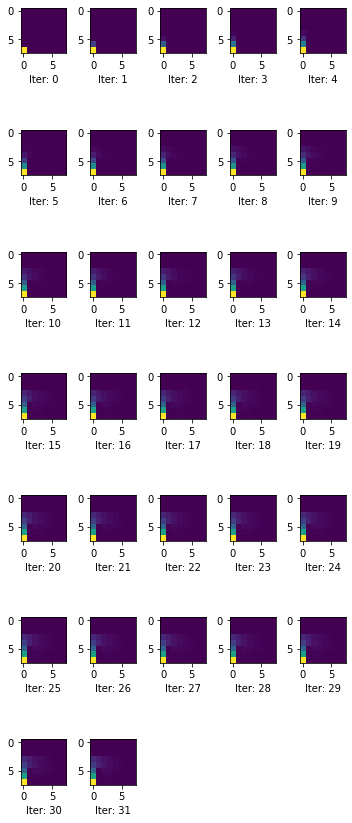

In [13]:
plot_value_history(value_history)

**Question**: Try running the above code with gamma = 0.3.  Does the agent converge to a successful policy (yes/no)? What is the role of gamma? *(5 pts)*:

**Answer**: The agent does not converge to a successful policy. We see that the value of the goal state is only estimated to have 0.4 value and all other states have a value near 0. Gamma is the discount factor which tells us how much to weigh future rewards by.

In [14]:
env = gym.make('Stochastic-8x8-FrozenLake-v0')
gamma = 0.3
value_info = value_iteration(env, gamma, max_iterations=int(1e3), tol=1e-4)
value, iters, value_history = value_info
policy = value_function_to_policy(env, gamma, value)
print('-----Policy: ')
print_policy(policy)
print('-----Value: ')
print_value(value)
print('-----Iterations: ', iters)

-----Policy: 
LLLLLLLL
LLLDDDDD
LLLLLLRD
DDDDDLLR
LUULLLDD
LLRUULLR
LLRLLLLL
DLLRDLDD
-----Value: 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000064 0.000012 0.000002 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000588 0.000061 0.000006 0.000001 0.000000 0.000000 0.000000 0.000000 
0.005268 0.000000 0.000001 0.000000 0.000000 0.000000 0.000000 0.000000 
0.046876 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.416661 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
-----Iterations:  7


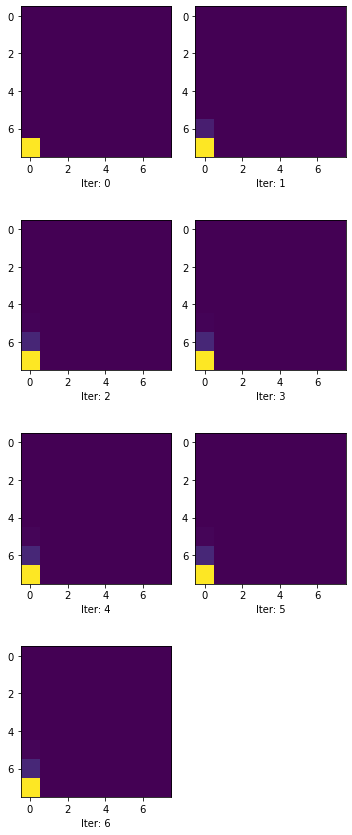

In [15]:
plot_value_history(value_history)

# Policy Iteration

Recall from class that value iteration is a special instance of generalized policy iteration, which alternates between 1 step of policy evaluation and 1 step of policy improvement.

Now we'll consider policy iteration, which alternates between many steps of policy evaluation and 1 step of policy improvement. Does that feel silly?

We will make a few notes:
- Let's consider N steps of policy evaluation + 1 step of policy improvement to be 1 iteration of value/policy iteration.
- It is not well understood why, but policy iteration and value iteration will attain the optimal policy in fewer iterations for different problems.
- While policy iteration has a hidden cost of N policy evaluation steps, it turns out that a full policy evaluation can be computed efficiently, since it is a linear operation. (We will not do this in this assignment, but trust us.) If employed efficiently, policy iteration can be viewed as a super-powered value iteration, with accurate policy evaluation and without a whole lot of extra computational cost.

Now, let's implement policy evaluation and policy improvement.

## Implement Policy Iteration

*(10 pts)*

First, implement the the high level wrapper `policy_iteration`. Here, we iteratively evaluate and then improve  our policy, an array of size `env.nS` with the action to take in every state. `evaluate_policy` returns a value function that we can feed into `improve_policy`. We will implement these submethods momentarily, but you can check out their function signatures below. We'll continue iterating on our policy until `improve_policy` tells us that the policy is stable.

In [70]:
def policy_iteration(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs policy iteration using the improve_policy and evaluate_policy methods.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.
    Returns
    -------
    (np.ndarray, np.ndarray, int, int, list)
       Returns optimal policy, value function, number of policy
       improvement iterations, number of value iterations, and a list
       of the history value functions.
    """
    policy = np.zeros(env.nS, dtype='int')
    value_history = [] # should contain the full history of value functions.
    policy_imp_step = 0 # number of total policy improvement iterations
    policy_eval_step = 0 # number of total value function iterations
    iter = 0
    while True:
        ### TODO: Fill in policy iteration main loop. ##########
        value_func, iter = evaluate_policy(env, gamma, policy, max_iterations = env.nS,tol = tol)
        value_history.append(value_func.copy())
        policy_eval_step += iter
        policy_stable, policy = improve_policy(env, gamma, value_func, policy)
        if policy_stable or iter >= max_iterations : break
        policy_imp_step += 1
        ##########################################################
    return policy, value_func, policy_imp_step, policy_eval_step, value_history

Next, implement the policy evaluation and update submethods.

To evaluate a policy, we calculate the value at each state by taking the action specified by the policy instead of looping over all possible actions from that state and using the maximum value (as done previously).

To improve the policy, you can extract the policy from the value function generated by evaluating the policy (similar to what we did previously).

*(30 pts)*


In [71]:
def evaluate_policy(env, gamma, policy, max_iterations=int(1e3), tol=1e-5):
    """Performs policy evaluation.
    Evaluates the value of a given policy by asynchronous DP.  Updates states in
    their 1-N order.
    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    policy: np.array
      The policy to evaluate. Maps states to actions.
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.
    Returns
    -------
    np.ndarray, int
      The value function for the given policy and the number of iterations till
      the value function converged.
    """
    value_func = np.zeros(env.nS)
    iter = 0
    while True:
        delta = 0
        ###### TODO: value function update (value_func) ##############
        for s in range(env.nS):
          a = policy[s]
          exp_a = sum([prob*(r + gamma*value_func[s2]) for prob, s2, r, _ in env.P[s][a]])
          delta = max(delta, abs(exp_a - value_func[s]))
          value_func[s] = exp_a
        ###################################################
        iter += 1
        if delta < tol or iter >= max_iterations:
            break
    return value_func, iter

def improve_policy(env, gamma, value_func, policy):
    """Performs policy improvement.
    Given a policy and value function, improves the policy.
    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    value_func: np.ndarray
      Value function for the given policy.
    policy: dict or np.array
      The policy to improve. Maps states to actions.
    Returns
    -------
    bool, np.ndarray
      Returns true if policy changed. Also returns the new policy.
    """
    policy_stable = True
    new_policy = np.random.randint(0, 4, (env.nS)).astype(np.int8)
    for idx in range(env.nS):
        old_action = policy[idx]
        p = env.P[idx]
        new_action = -1
        best_q = -np.inf
        ###### TODO: use value function to get new action (new_action) ######
        for a in range(env.nA):
          exp_a = sum([prob*(r + gamma*value_func[s2]) for prob, s2, r, _ in env.P[idx][a]])
          if exp_a > best_q:
            new_action = a
            best_q = exp_a
        ###################################################
        new_policy[idx] = new_action
        if new_action != old_action:
            policy_stable = False
    return policy_stable, new_policy

## Run Policy Iteration

Assuming your above implementation is correct, you should be able to run the below code to evaluate policy iteration on Frozen Lake.

In [72]:
env = gym.make('Stochastic-8x8-FrozenLake-v0')
gamma = 0.9
policy_info = policy_iteration(env, gamma, max_iterations=int(1e3), tol=1e-3)
new_policy, value_func, policy_imp_step, policy_eval_step, value_history = policy_info
policy = value_function_to_policy(env, gamma, value)
print('New policy: ')
print_policy(new_policy)
print('Value: ')
print_value(value_func)
print('Number of policy improvement steps: ', policy_imp_step)
print('Total number of policy evaluation steps: ', policy_eval_step)

New policy: 
DRRRRLLL
UUUURUUD
LLLLLLRR
DDDDDLLR
LUULLLDU
LLRUULLR
LLRLLLLL
DLLRDLDD
Value: 
0.000109 0.000219 0.000412 0.000698 0.000987 0.000761 0.000519 0.000367 
0.000116 0.000213 0.000421 0.000838 0.001755 0.000904 0.000539 0.000410 
0.000000 0.000000 0.000000 0.000000 0.004136 0.000000 0.000298 0.000494 
0.090393 0.060563 0.036568 0.021488 0.012289 0.005985 0.000000 0.000825 
0.152677 0.076039 0.040690 0.023381 0.013891 0.007830 0.002791 0.001527 
0.267162 0.000000 0.019410 0.016027 0.010842 0.006361 0.000000 0.000644 
0.471516 0.000000 0.008404 0.008780 0.000000 0.002604 0.000000 0.000000 
0.833322 0.000000 0.000000 0.004976 0.003079 0.002400 0.001383 0.000950 
Number of policy improvement steps:  7
Total number of policy evaluation steps:  152


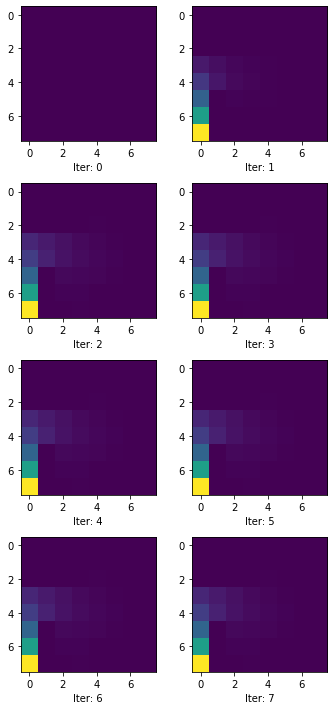

In [69]:
plot_value_history(value_history)


Note that both value and policy iteration can solve the `Frozen Lake` environment (if one can't, you've done something wrong). 

**Questions** *(20 pts)*:
- How many iterations (i.e. policy improvement steps) were required by policy iteration? 
  - **Answer:** 7

- How many policy improvement steps were required by value iteration (each new value function is implicitly a new policy)? 
  - **Answer:** 32

- If one method took longer to converge, postulate an explanation for this.
   - **Answer**: 
  


One common benchmark for reinforcment learning algorithms is *sample complexity*: the number of interactions the agent must have with the environment to learn a policy.  In policy iteration, we can approximate this as the number of "actions" for which policy improvement is run.

**Question**:  Compute the sample complexity to solve 8x8 FrozenLake.  What number do you get? (10 pts)

**Answer**: 

# Q-learning

In the above two algorithms, we had access to the entire MDP: all of the states, with all of the transition probabilities between them.  Unfortunately, this is usually not the case.

Below we will implement Q-learning, which is *model free*: it does not require full knowledge of environment dynamics, and instead will try to learn a policy purely through exploration and exploitation.

For pedantic purposes*, you have obtained some microspikes for your frozen lake and the environment is no longer slippery, hurrah! In other words, whatever action you decide to take you will actually take instead of randomly going perpendicularly quite often.

Fill in the missing functions in the `QLearningAgent` below.

*(50 pts)*

$_\text{*with a slippery environment and epsilon random exploration as we'll implement below, there's so much randomness that we don't see anything interesting from tabular rasa Q-learning in reasonable time frames. in practice, many real world environments don't have as much randomness as frozen lake (where 66\% of the time what you act doesn't actually happen}$

In [30]:
env_name = 'Deterministic-8x8-FrozenLake-v0'
if env_name not in gym.envs.registry.env_specs:
    register(
        id=env_name,
        entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
        kwargs={'map_name': None,
                'is_slippery': False,
                'desc': MAPS['8x8'],
                },
        max_episode_steps=100)

In [62]:
@dataclass
class QLearningAgent:
    env: gym.Env
    learning_rate: float
    gamma: float
    initial_epsilon: float
    min_epsilon: float
    max_decay_episodes: int
    init_q_value: float = 0.

    def __post_init__(self):
        self.num_states = env.nS
        self.reset()

    def decay_epsilon(self):
        ### TODO: decay epsilon by ep_reduction while respecting min_epsilon ################
        ###.      this function is called every episode
        new_epsilon = self.epsilon - self.ep_reduction
        self.epsilon = max(new_epsilon,self.min_epsilon)
        #####################################################################
    
    def reset(self):
        self.epsilon = self.initial_epsilon
        self.ep_reduction = (self.epsilon - self.min_epsilon) / float(self.max_decay_episodes)
        self.Q = np.ones((self.num_states, self.env.nA)) * self.init_q_value

    def update_Q(self, state, next_state, action, reward, done):
        ### TODO: update self.Q given new experience. #######################
        if done:
          self.Q[state,action] = reward
        else:
          y = reward + self.gamma*max(self.Q[next_state,:])
          e = y - self.Q[state,action]
          self.Q[state,action] = self.Q[state,action] + self.learning_rate*e
        #####################################################################

    def get_action(self, state):
        ### TODO: select an action given self.Q and self.epsilon ############
        if np.random.random() <= self.epsilon:
          return np.random.randint(4)
        else:
          return np.argmax(self.Q[state,:])
        #####################################################################

The below code is scaffolding to instantiate and run the above Q-Learning agent.  Feel free to examine it to help you implement `QLearningAgent`.

In [63]:
@dataclass
class QLearningEngine:
    env: gym.Env
    agent: Any
    max_episodes: int
    
    def run(self, n_runs=1):
        rewards = []
        log = []
        for i in tqdm(range(n_runs), desc='Runs'):
            ep_rewards = []
            self.agent.reset()
            # we plot the smoothed return values
            smooth_ep_return = deque(maxlen=100)
            for t in tqdm(range(self.max_episodes), desc='Episode'):
                state = self.env.reset()
                ret = 0
                while True:
                    action = self.agent.get_action(state)
                    next_state, reward, done, info = self.env.step(action)
                    true_done = done and not info.get('TimeLimit.truncated', False)
                    self.agent.update_Q(state, next_state, action, reward, true_done)
                    ret += reward
                    state = next_state
                    if done:
                        break
                self.agent.decay_epsilon()
                smooth_ep_return.append(ret)
                ep_rewards.append(np.mean(smooth_ep_return))
            rewards.append(ep_rewards)
            run_log = pd.DataFrame({'return': ep_rewards,  
                                    'episode': np.arange(len(ep_rewards)), 
                                    'iqv': self.agent.init_q_value})
            log.append(run_log)
        return log

def qlearning_sweep(init_q_values, n_runs=4, max_episodes=100000, epsilon=0.9, learning_rate=0.8):
    logs = dict()
    pbar = tqdm(init_q_values)
    agents = []
    for iqv in pbar:
        pbar.set_description(f'Initial q value:{iqv}')
        env=gym.make('Deterministic-8x8-FrozenLake-v0')
        agent = QLearningAgent(env=env,
                               learning_rate=learning_rate,
                               gamma=0.99,
                               initial_epsilon=epsilon,
                               min_epsilon=0.0,
                               max_decay_episodes=max_episodes,
                               init_q_value=iqv)
        engine = QLearningEngine(env=env, agent=agent, max_episodes=max_episodes)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        logs[f'{iqv}'] = ep_log

        agents.append(agent)
    logs = pd.concat(logs, ignore_index=True)
    return logs, agents

Once the agent is implemented, run the below code to try it out on FrozenLake!

  0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/3 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

Runs:   0%|          | 0/3 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

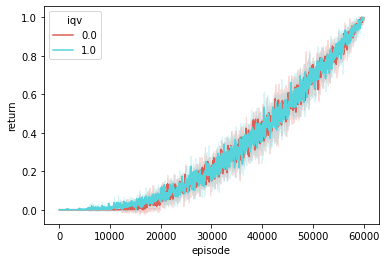

In [73]:
init_q_values = [0., 1.]
eps_logs, eps_agents = qlearning_sweep(init_q_values, n_runs=3, max_episodes=60000, epsilon=0.9)
plot(eps_logs, x_key='episode', y_key='return', legend_key='iqv', estimator='mean', ci='sd')

### Questions

Using the above parameters (`init_q_values = [0., 1.]`, `epsilon=0.9`):
- Print the policy for both agents in the cell below. Do both converge? (5 pts)
  - **Answer:**  For this random seed, both agents converged.
- How does the performance compare between the initial Q values during the learning process? Why is there a difference if any? (10 pts)
  - **Answer:**  For this random seed, there is no substantial difference in performance for the different Q value initializations.
  


If you set `epsilon=0.0` for the same `init_q_values = [0., 1.]` and set `max_episodes=1000`:
- How many steps does the policy take now? Why is the `iqv = 1.0` policy converging faster as compared to with a higher value of initial_epsilon? (10 pts)
  - **Answer:** Since we are taking 100 steps per episode, the policy now takes 1000×100 = 100,000 steps. The policy with iqv = 1 converges faster now because it spends less time exploring and switches to exploitation much earlier. Since the state space isn't that large, there isnt much exploration required.
  

In [79]:
### TODO: print policy for agents with each of the init q_values. ########
agent0, agent1 = eps_agents
print("Resulting policy when iqc = 0: \n", np.argmax(agent0.Q,axis=1).reshape((8,8)))
print("Resulting policy when iqc = 1: \n", np.argmax(agent1.Q,axis=1).reshape((8,8)))
########################################################################

Resulting policy when iqc = 0: 
 [[2 1 1 1 1 0 0 0]
 [2 2 2 2 1 0 0 0]
 [0 0 0 0 1 0 3 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 3 0 0 3 0 0]
 [1 0 3 0 0 3 0 0]
 [2 0 0 3 0 3 0 0]]
Resulting policy when iqc = 1: 
 [[1 1 1 1 1 0 0 0]
 [2 2 2 2 1 0 0 0]
 [0 0 0 0 1 0 2 1]
 [1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0]
 [1 0 3 0 0 0 0 3]
 [1 0 3 0 0 3 0 0]
 [2 0 0 3 0 0 0 1]]


  0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/3 [00:00<?, ?it/s]

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/3 [00:00<?, ?it/s]

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

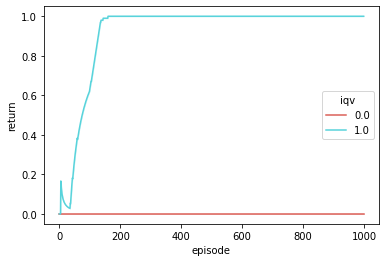

In [65]:
init_q_values = [0., 1.]
eps_logs, eps_agents = qlearning_sweep(init_q_values, n_runs=3, max_episodes=1000, epsilon=0)
plot(eps_logs, x_key='episode', y_key='return', legend_key='iqv', estimator='mean', ci='sd')

## Q-Learning Sample Complexity

Remember that we computed the *sample complexity* of Policy Iteration on 8x8 FrozenLake.

**Question:** With Q-learning, our sample complexity requires more than 60,000 episodes with 100 steps (i.e,. actions taken by the agent and executed in the environment) per episode. Why is the sample complextiy so much higher than value and policy iteration? (20 pts)
- **Answer**: Since we had such a high $\epsilon$ with Q-learning, a lot of steps were wasted to randomly explore the environment. On the other hand, with value and policy iteration we had access to the entire MDP, which means that we did not have to waste any time learning about the environment, we could directly apply the Bellman equation with knowledge of the terminal value of each state and the associated transition probabilities.

# Survey (bonus, 10 pts)
Please fill out [this anonymous survey](https://docs.google.com/forms/d/e/1FAIpQLSc24Peg-H269fxBOarZ5MdNgsHFe2ZZ_t90Wd_KjO3jz2cuCQ/viewform?usp=sf_link) and enter the code below to receive credit. Thanks!

**Bonus code**: traffic_cones_on_the_frozen_charles

# Submission
Run the below cell to generate an html file with your notebook. You can also follow the piazza instructions for PDF generation

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
!jupyter nbconvert --to html '/content/drive/My Drive/path_to_notebook.ipynb'